In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*torch.load.*weights_only=False.*")

import time

import torch
from _dattri.utlis import compute_pairwise_distance_metrics, compute_pairwise_inner_product_rank_correlation
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def sparse_rand_proj(vec, proj_dim, delta=None, eps=None, proj_seed=0):
    torch.manual_seed(proj_seed)

    # Handle delta and eps
    if delta is None and eps is not None:
        delta = 1 / torch.exp(torch.tensor(proj_dim * eps**2 / 12))
    elif eps is None and delta is not None:
        eps = torch.sqrt(12 * torch.log(torch.tensor(1 / delta)) / proj_dim)
    else:
        raise ValueError("Either delta or eps must be provided.")

    # Calculate the number of non-zero projections per vector element
    c = 16 * torch.log(torch.tensor(1 / delta)) * (torch.log(torch.tensor(proj_dim / delta)) ** 2) / eps
    c_int = int(c)

    non_zero_indices = torch.nonzero(vec).squeeze()
    num_non_zero = non_zero_indices.shape[0]

    if non_zero_indices.numel() == 0:
        return torch.zeros(proj_dim, device=vec.device)


    rand_indices = torch.randint(proj_dim, (num_non_zero, c_int), device=vec.device)
    rand_signs = (torch.randint(0, 2, (num_non_zero, c_int), device=vec.device) * 2 - 1)

    # Multiply the non-zero elements of vec by their corresponding random signs
    non_zero_vals = vec[non_zero_indices].unsqueeze(1)  # Shape (num_non_zero, 1)
    scaled_vals = non_zero_vals * rand_signs  # Shape (num_non_zero, c_int)

    vec_p = torch.zeros(proj_dim, device=vec.device)

    # Perform vectorized index addition (summing over c_int for each non-zero element)
    vec_p.index_add_(0, rand_indices.flatten(), scaled_vals.flatten())
    vec_p /= c_int ** 0.5

    return vec_p

100%|██████████| 7/7 [00:01<00:00,  4.10it/s]


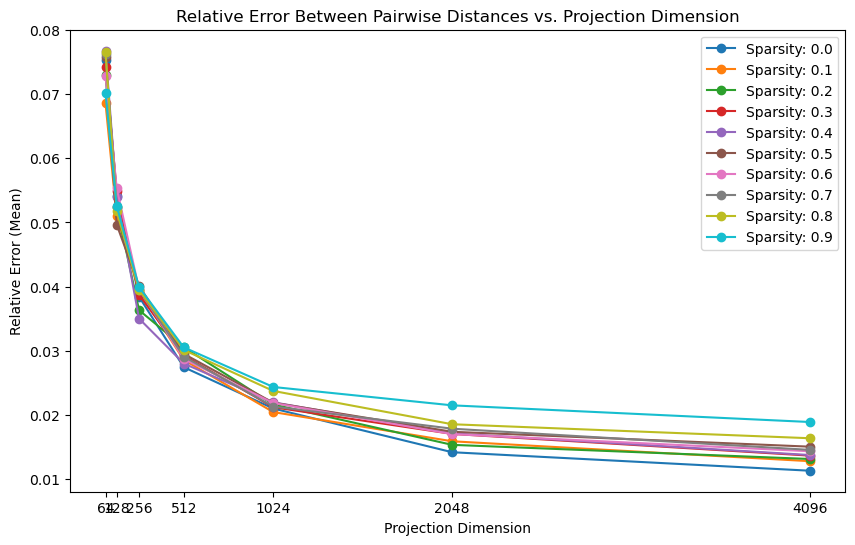

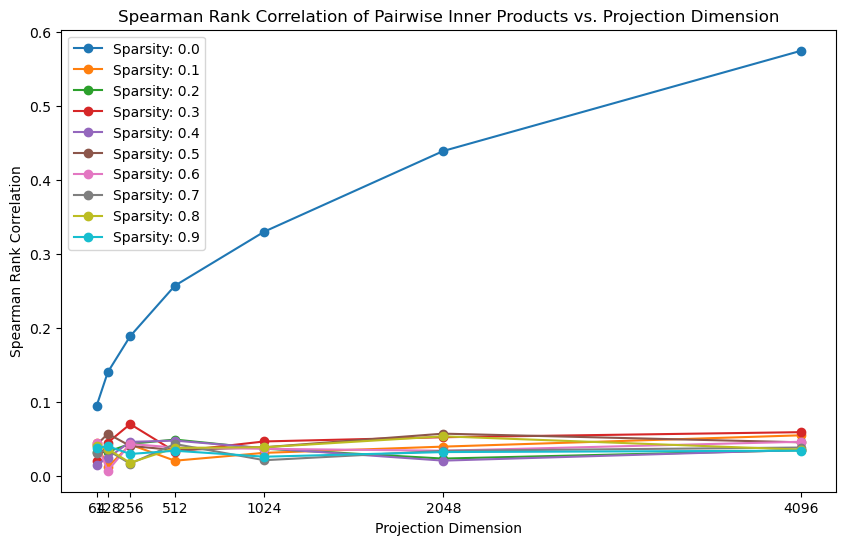

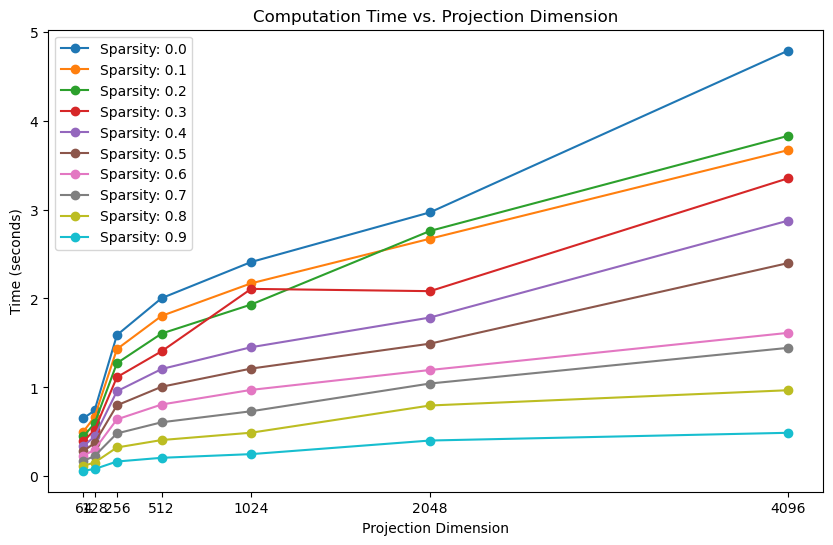

In [3]:

def test_random_projection_quality(projection_dims, batch_size=100, original_dim=4096, sparsity_levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    # Store results for each sparsity level
    relative_errors_dist = {sparsity: [] for sparsity in sparsity_levels}
    spearman_correlations = {sparsity: [] for sparsity in sparsity_levels}
    times = {sparsity: [] for sparsity in sparsity_levels}

    for sparsity in sparsity_levels:
        # Create a batch of random vectors
        rand_vec = torch.randn(batch_size, original_dim).float().to('cuda')

        # Sparsify the vectors by randomly setting a fraction (sparsity) of elements to zero
        num_elements_to_drop = int(sparsity * original_dim)
        if num_elements_to_drop > 0:
            for i in range(batch_size):
                indices_to_drop = torch.randperm(original_dim)[:num_elements_to_drop]
                rand_vec[i, indices_to_drop] = 0

        for proj_dim in tqdm(projection_dims):
            rand_vec_p = torch.zeros(batch_size, proj_dim).float().to('cuda')

            # Measure the time taken for random projection
            start_time = time.time()
            for i in range(batch_size):
                # Apply sparse random projection
                rand_vec_p[i] = sparse_rand_proj(
                    rand_vec[i],
                    proj_dim=proj_dim,
                    delta=0.2,
                    proj_seed=proj_dim,
                )
            end_time = time.time()

            # Calculate relative error for the current projection dimension
            relative_error = compute_pairwise_distance_metrics(rand_vec, rand_vec_p)
            relative_errors_dist[sparsity].append(relative_error)

            # Calculate Spearman rank correlation for inner products
            spearman_corr = compute_pairwise_inner_product_rank_correlation(rand_vec, rand_vec_p)
            spearman_correlations[sparsity].append(spearman_corr)

            # Record the time taken
            times[sparsity].append(end_time - start_time)

    # Plotting relative errors for each sparsity level
    plt.figure(figsize=(10, 6))
    for sparsity in sparsity_levels:
        plt.plot(projection_dims, relative_errors_dist[sparsity], marker='o', label=f'Sparsity: {sparsity}')
    plt.xticks(projection_dims)
    plt.title("Relative Error Between Pairwise Distances vs. Projection Dimension")
    plt.xlabel("Projection Dimension")
    plt.ylabel("Relative Error (Mean)")
    plt.legend()
    plt.show()

    # Plotting Spearman rank correlations for each sparsity level
    plt.figure(figsize=(10, 6))
    for sparsity in sparsity_levels:
        plt.plot(projection_dims, spearman_correlations[sparsity], marker='o', label=f'Sparsity: {sparsity}')
    plt.xticks(projection_dims)
    plt.title("Spearman Rank Correlation of Pairwise Inner Products vs. Projection Dimension")
    plt.xlabel("Projection Dimension")
    plt.ylabel("Spearman Rank Correlation")
    plt.legend()
    plt.show()

    # Plotting computation times for each sparsity level
    plt.figure(figsize=(10, 6))
    for sparsity in sparsity_levels:
        plt.plot(projection_dims, times[sparsity], marker='o', label=f'Sparsity: {sparsity}')
    plt.xticks(projection_dims)
    plt.title("Computation Time vs. Projection Dimension")
    plt.xlabel("Projection Dimension")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.show()

# List of projection dimensions to test
projection_dims = [64, 128, 256, 512, 1024, 2048, 4096]

# Run the test and plot the results
test_random_projection_quality(projection_dims, original_dim=8192)